In [1]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [2]:
!unzip -q EuroSAT_small.zip

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
from torch.utils.data import DataLoader, Dataset
from glob import glob
from itertools import chain
import random

class EuroSATDataset(Dataset):

    def __init__(self, root, train_flag = True):

        self.train_flag = train_flag
        self.root = root
        self.images_paths = [glob(f'{root}/{folder}/*.jpg') for folder in os.listdir(f"{root}")]
        self.images_paths = list(chain.from_iterable(self.images_paths))
        random.shuffle(self.images_paths)

        # комментарий преподавателя: на текущей машине очень мало мощностей, максимально обрезаем данные
        # для обучения и валидации в соотношении 100/30

        self.count = {True: 100}
        self.count[False] = 30


        self.classes_names = {class_name:label for label, class_name in enumerate(os.listdir(f"{root}"))}
        self.labels = [self.classes_names[os.path.basename(os.path.dirname(path))] for path in self.images_paths]

        # применяем аугментациб данных. В качестве ДЗ расширите список применяемых преобразований.
        self.transform_train = transforms.Compose([
            transforms.Normalize(mean=[0.485,0.456, 0.406],std=[0.229, 0.224, 0.225]),
            torchvision.transforms.RandomResizedCrop((224,224))
                                                  ])
        self.transform_test =  transforms.Normalize(mean=[0.485,0.456, 0.406],std=[0.229, 0.224, 0.225])


    def __len__(self):
        return self.count[self.train_flag]

    def __getitem__(self, index):
        if (self.train_flag):
            index = index % self.count[True]
        else:
            index = self.count[True] + index % self.count[False]
        image_path = self.images_paths[index]
        image = cv2.imread(image_path)[:,:,::-1]
        image = cv2.resize(image, (224,224))
        image = torch.tensor(image/255).permute(2,0,1).to(device)

        if self.train_flag:
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        label = self.labels[index]

        return image.float().to(device), torch.tensor([label]).float().to(device)

In [23]:
data =  EuroSATDataset('./EuroSAT_small/2750', train_flag=True)
len(data)

100

Image Size: 224 x 224 x 3
Label: tensor([5.], device='cuda:0')
River


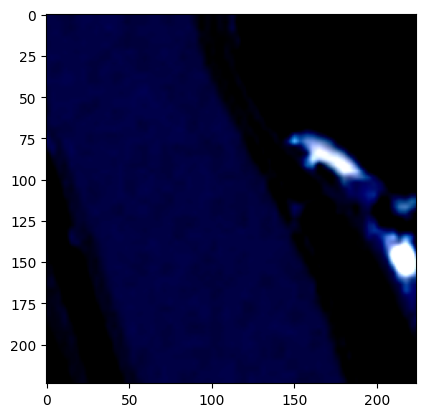

In [24]:
import random
import cv2

image, label = data[random.randint(0, len(data))]
print(f"Image Size: {image.shape[2]} x {image.shape[1]} x {image.shape[0]}")
print(f"Label: {label}")
print([key  for key, value in data.classes_names.items() if value == label][0])
plt.imshow(image.permute(1,2,0).cpu().numpy())
plt.show()

In [25]:
train_dataset = EuroSATDataset('./EuroSAT_small/2750')
test_dataset = EuroSATDataset('./EuroSAT_small/2750',train_flag = False)
train_dataset_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, drop_last=True)

In [26]:
# fine turning MODEL
# change last model layer (model.fc) for classification on EuroSAT set of classes, 10 classes
# (not 1000 like for ImageNet dataset pretrained weights)
# pretrained models https://pytorch.org/vision/stable/models.html

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features,10)
model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [27]:
# Specify number of epochs and learning rate
lr = 1e-3

# Specify criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [28]:
def train_step(model, loss_function, optimizer, image, label):
    model.train()
    optimizer.zero_grad()
    prediction = model(image)
    #print(prediction)
    #print(label)
    loss = loss_function(prediction.squeeze(), label.long().squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

In [29]:
@torch.no_grad()
def accuracy(model, loss_function, image, label):
    model.eval()
    prediction = model(image)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == label.int().squeeze()
    return is_correct.cpu().numpy().tolist()

In [30]:
@torch.no_grad()
def validation_loss(model, loss_function, image, label):
    model.eval()
    prediction = model(image)
    loss = loss_function(prediction.squeeze(), label.long().squeeze())
    return loss.item()

In [31]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

n_epochs = 10
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_epoch_losses = []
    train_epoch_accuracies = []
    for idx,(image, label) in enumerate(train_dataset_loader):
        loss = train_step(model, criterion, optimizer, image, label)
        train_epoch_losses.append(loss)
        print(loss)
        #if (idx + 1) %100 == 0: print(loss)
    train_epoch_loss = np.mean(train_epoch_losses)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    train_losses.append(train_epoch_loss)

    for idx,(image, label) in enumerate(train_dataset_loader):
        is_correct = accuracy(model, criterion, image, label)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print(f"Train Accuracy: {train_epoch_accuracy*100:.2f}%")
    train_accuracies.append(train_epoch_accuracy)

    test_epoch_losses = []
    test_epoch_accuracies = []
    for idx,(image, label) in enumerate(test_dataset_loader):
        #print(label)
        loss = validation_loss(model, criterion, image, label)
        test_epoch_losses.append(loss)
        is_correct = accuracy(model, criterion, image, label)
        test_epoch_accuracies.extend(is_correct)
    test_epoch_loss = np.mean(test_epoch_losses)
    print(f"Test Loss: {test_epoch_loss:.4f}")
    test_losses.append(test_epoch_loss)
    test_epcoh_accuracy = np.mean(test_epoch_accuracies)
    print(f"Test Accuracy: {test_epcoh_accuracy*100:.2f}%")
    test_accuracies.append(test_epcoh_accuracy)

Epoch: 1
2.6754589080810547
2.4446334838867188
2.2975125312805176
Train Loss: 2.4725
Train Accuracy: 3.12%
Test Loss: 2.3515
Test Accuracy: 3.33%
Epoch: 2
2.1405394077301025
2.096820592880249
1.8661255836486816
Train Loss: 2.0345
Train Accuracy: 10.42%
Test Loss: 2.2510
Test Accuracy: 10.00%
Epoch: 3
1.808340072631836
1.704218864440918
1.677619457244873
Train Loss: 1.7301
Train Accuracy: 20.83%
Test Loss: 2.0703
Test Accuracy: 16.67%
Epoch: 4
1.4904274940490723
1.5269757509231567
1.3579407930374146
Train Loss: 1.4584
Train Accuracy: 48.96%
Test Loss: 1.8690
Test Accuracy: 30.00%
Epoch: 5
1.36862313747406
1.1716930866241455
1.2316466569900513
Train Loss: 1.2573
Train Accuracy: 71.88%
Test Loss: 1.6220
Test Accuracy: 50.00%
Epoch: 6
1.0672907829284668
1.157966136932373
1.1166081428527832
Train Loss: 1.1140
Train Accuracy: 73.96%
Test Loss: 1.4339
Test Accuracy: 63.33%
Epoch: 7
1.0431604385375977
1.1051788330078125
1.0155494213104248
Train Loss: 1.0546
Train Accuracy: 83.33%
Test Loss: 1.

In [32]:
# example of model saving
model_dir = "./models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'best_model.pth')
model_file
torch.save(model.state_dict(), model_file)

In [33]:
torch.save(model.state_dict(), model_file)

In [34]:
# EXAMPLE OF MODEL LOADING
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features,10)
model = model.to(device)

In [36]:
# example of loading model from the file
model.load_state_dict(torch.load(PATH, weights_only=True))

NameError: name 'PATH' is not defined

In [18]:
# 1. Выберите иную модель из доступных предтренированных моделей: https://pytorch.org/vision/main/models.html
# Загрузите предобученные веса.
# 2. Преобразуйте выходной слой модели для дообучения на текущей задаче классификации.
# 3. Дообучите модель.
# 3.1 Проводите обучение, по возможности, на всем доступном наборе данных. Если вычислительных мощностей достаточно,
# можете использовать полный набор данных EuroSAT (без _small).
# 4. Сохраните модель с лучшими параметрами качества.

# Изучите аугментацию данных https://pytorch.org/vision/main/transforms.html
# Добавьте дополнительную аугментацию данных для шага тренировки.
# Проведите дообучение еще раз. Исследуйте, изменилась ли скорость сходимости сети. Какова точность классификации?

#Домашняя работа

In [19]:
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT) #загружаем модель densenet121


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 98.3MB/s]


In [20]:
model.classifier = torch.nn.Linear(model.classifier.in_features, 10)


In [44]:
import torch

# Путь для сохранения модели
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


model_file = os.path.join(model_dir, 'best_model.pth')

# Переменная для хранения лучшей точности
best_accuracy = 0.0

n_epochs = 10
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")

    # Обучение
    train_epoch_losses = []
    train_epoch_accuracies = []
    for idx, (image, label) in enumerate(train_dataset_loader):
        loss = train_step(model, criterion, optimizer, image, label)
        train_epoch_losses.append(loss)

    train_epoch_loss = np.mean(train_epoch_losses)
    print(f"Train Loss: {train_epoch_loss:.4f}")

    # Точность на тренировочной выборке
    for idx, (image, label) in enumerate(train_dataset_loader):
        is_correct = accuracy(model, criterion, image, label)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print(f"Train Accuracy: {train_epoch_accuracy * 100:.2f}%")

    # Валидация
    test_epoch_losses = []
    test_epoch_accuracies = []
    for idx, (image, label) in enumerate(test_dataset_loader):
        loss = validation_loss(model, criterion, image, label)
        test_epoch_losses.append(loss)
        is_correct = accuracy(model, criterion, image, label)
        test_epoch_accuracies.extend(is_correct)

    test_epoch_loss = np.mean(test_epoch_losses)
    test_epoch_accuracy = np.mean(test_epoch_accuracies)

    print(f"Test Loss: {test_epoch_loss:.4f}")
    print(f"Test Accuracy: {test_epoch_accuracy * 100:.2f}%")

    # Если текущая точность на тесте лучше, чем лучшая точность, обновляем и сохраняем модель
    if test_epoch_accuracy > best_accuracy:
        best_accuracy = test_epoch_accuracy
        print(f"New best model found! Saving model...")

        # Сохранение модели
        torch.save(model.state_dict(), model_file)



Epoch: 1
Train Loss: 0.1929
Train Accuracy: 94.79%
Test Loss: 0.2196
Test Accuracy: 96.67%
New best model found! Saving model...
Epoch: 2
Train Loss: 0.2106
Train Accuracy: 96.88%
Test Loss: 0.2270
Test Accuracy: 96.67%
Epoch: 3
Train Loss: 0.2171
Train Accuracy: 98.96%
Test Loss: 0.2262
Test Accuracy: 96.67%
Epoch: 4
Train Loss: 0.2291
Train Accuracy: 97.92%
Test Loss: 0.2198
Test Accuracy: 96.67%
Epoch: 5
Train Loss: 0.1789
Train Accuracy: 96.88%
Test Loss: 0.2197
Test Accuracy: 96.67%
Epoch: 6
Train Loss: 0.1982
Train Accuracy: 96.88%
Test Loss: 0.2167
Test Accuracy: 96.67%
Epoch: 7
Train Loss: 0.2394
Train Accuracy: 95.83%
Test Loss: 0.2110
Test Accuracy: 96.67%
Epoch: 8
Train Loss: 0.2319
Train Accuracy: 98.96%
Test Loss: 0.2008
Test Accuracy: 96.67%
Epoch: 9
Train Loss: 0.1785
Train Accuracy: 94.79%
Test Loss: 0.1885
Test Accuracy: 96.67%
Epoch: 10
Train Loss: 0.1766
Train Accuracy: 96.88%
Test Loss: 0.1936
Test Accuracy: 96.67%


# Добавление аргументации и дальнеешее дообучение

In [45]:
from torchvision import transforms

class EuroSATDataset(Dataset):

    def __init__(self, root, train_flag=True):
        self.train_flag = train_flag
        self.root = root
        self.images_paths = [glob(f'{root}/{folder}/*.jpg') for folder in os.listdir(f"{root}")]
        self.images_paths = list(chain.from_iterable(self.images_paths))
        random.shuffle(self.images_paths)

        self.count = {True: 100}
        self.count[False] = 30

        self.classes_names = {class_name: label for label, class_name in enumerate(os.listdir(f"{root}"))}
        self.labels = [self.classes_names[os.path.basename(os.path.dirname(path))] for path in self.images_paths]

        # Добавляем дополнительные аугментации
        self.transform_train = transforms.Compose([
            transforms.RandomResizedCrop(224),  # случайное обрезание с изменением размера
            transforms.RandomHorizontalFlip(),  # случайный горизонтальный флип
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # изменение яркости, контраста, насыщенности, оттенка
            transforms.RandomRotation(15),  # случайное вращение на угол до 15 градусов
            transforms.ToTensor(),  # преобразуем изображение в тензор
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # нормализация
        ])

        # Для тестовых данных только нормализация и изменение размера
        self.transform_test = transforms.Compose([
            transforms.Resize(256),  # изменение размера
            transforms.CenterCrop(224),  # обрезка центральной части
            transforms.ToTensor(),  # преобразуем изображение в тензор
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # нормализация
        ])

    def __len__(self):
        return self.count[self.train_flag]

    def __getitem__(self, index):
        if self.train_flag:
            index = index % self.count[True]
        else:
            index = self.count[True] + index % self.count[False]

        image_path = self.images_paths[index]
        image = cv2.imread(image_path)[:,:,::-1]  # читаем изображение (BGR -> RGB)
        image = cv2.resize(image, (224, 224))  # изменение размера

        # Преобразуем в тензор и применяем аугментации
        image = torch.tensor(image / 255).permute(2, 0, 1).to(device)  # нормализуем и перемещаем на GPU

        # Применяем аугментации в зависимости от того, является ли это обучающим набором
        if self.train_flag:
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)

        label = self.labels[index]
        return image.float().to(device), torch.tensor([label]).long().to(device)  # возвращаем данные на GPU


Epoch: 1
Train Loss: 0.1735
Train Accuracy: 94.79%
Test Loss: 0.1866
Test Accuracy: 96.67%
Epoch: 2
Train Loss: 0.2178
Train Accuracy: 94.79%
Test Loss: 0.1889
Test Accuracy: 96.67%
Epoch: 3
Train Loss: 0.1399
Train Accuracy: 97.92%
Test Loss: 0.1663
Test Accuracy: 96.67%
Epoch: 4
Train Loss: 0.1552
Train Accuracy: 97.92%
Test Loss: 0.1565
Test Accuracy: 96.67%
Epoch: 5
Train Loss: 0.1760
Train Accuracy: 96.88%
Test Loss: 0.1552
Test Accuracy: 96.67%
Epoch: 6
Train Loss: 0.1222
Train Accuracy: 95.83%
Test Loss: 0.1511
Test Accuracy: 96.67%
Epoch: 7
Train Loss: 0.1787
Train Accuracy: 100.00%
Test Loss: 0.1463
Test Accuracy: 96.67%
Epoch: 8
Train Loss: 0.1607
Train Accuracy: 98.96%
Test Loss: 0.1483
Test Accuracy: 96.67%
Epoch: 9
Train Loss: 0.1661
Train Accuracy: 98.96%
Test Loss: 0.1613
Test Accuracy: 96.67%
Epoch: 10
Train Loss: 0.1444
Train Accuracy: 96.88%
Test Loss: 0.1752
Test Accuracy: 96.67%


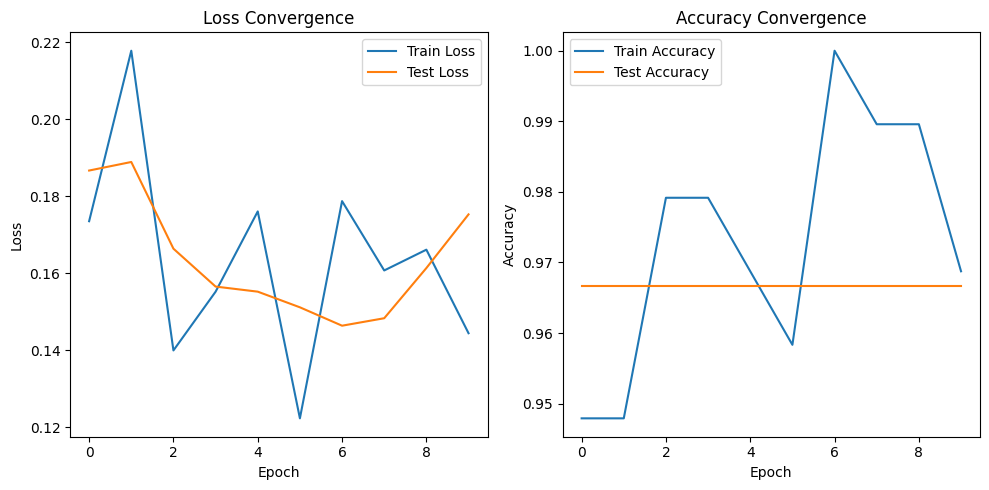

In [46]:
import matplotlib.pyplot as plt

# Переменные для хранения результатов
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Добавим код для построения графиков сходимости
def plot_convergence(train_losses, test_losses, train_accuracies, test_accuracies):
    # Графики потерь
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Convergence')
    plt.legend()

    # Графики точности
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Convergence')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Дообучение модели с аугментацией
n_epochs = 10
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")

    # Обучение
    train_epoch_losses = []
    train_epoch_accuracies = []
    for idx, (image, label) in enumerate(train_dataset_loader):
        loss = train_step(model, criterion, optimizer, image, label)
        train_epoch_losses.append(loss)

    train_epoch_loss = np.mean(train_epoch_losses)
    print(f"Train Loss: {train_epoch_loss:.4f}")

    # Точность на тренировочной выборке
    for idx, (image, label) in enumerate(train_dataset_loader):
        is_correct = accuracy(model, criterion, image, label)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print(f"Train Accuracy: {train_epoch_accuracy * 100:.2f}%")

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)

    # Валидация
    test_epoch_losses = []
    test_epoch_accuracies = []
    for idx, (image, label) in enumerate(test_dataset_loader):
        loss = validation_loss(model, criterion, image, label)
        test_epoch_losses.append(loss)
        is_correct = accuracy(model, criterion, image, label)
        test_epoch_accuracies.extend(is_correct)

    test_epoch_loss = np.mean(test_epoch_losses)
    test_epoch_accuracy = np.mean(test_epoch_accuracies)

    print(f"Test Loss: {test_epoch_loss:.4f}")
    print(f"Test Accuracy: {test_epoch_accuracy * 100:.2f}%")

    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_accuracy)

# Построение графиков сходимости
plot_convergence(train_losses, test_losses, train_accuracies, test_accuracies)

